# Find hospitals closest to an incident

The `network` module of the ArcGIS API for Python can be used to solve different types of network analysis operations. In this sample, we see how to find the hospital that is closest to an incident.

## Closest facility

The closest facility solver provides functionality for finding out the closest locations to a particular input point. This solver would be useful in cases when you have an incident and need to find the closest facility or need to get information on the travel time and the distance to each of the facilities from an incident point for reporting purposes.

![](http://desktop.arcgis.com/en/arcmap/latest/extensions/network-analyst/GUID-96C273DB-6A24-4D42-AADA-975A33B44F3D-web.png)

When finding closest facilities, you can specify how many to find and whether the direction of travel is toward or away from them. The closest facility solver displays the best routes between incidents and facilities, reports their travel costs, and returns driving directions.

### Connect to your GIS
As a first step, you would need to establish a connection to your organization which could be an ArcGIS Online organization or an ArcGIS Enterprise.

In [1]:
from IPython.display import HTML
import pandas as pd
import arcgis.network as network
from arcgis import geocoding
from arcgis.features import Feature, FeatureSet
from IPython.display import HTML
from arcgis.gis import GIS

In [2]:
gis = GIS('https://www.arcgis.com', 'arcgis_python', 'P@ssword123')

### Create a Network Layer
To perform any network analysis (such as finding the closest facility, the best route between multiple stops, or service area around a facility), you would need to create a `NetworkLayer` object. In this sample, since we are solving for closest facilities, we need to create a `ClosestFacilityLayer` which is a type of `NetworkLayer`.

To create any `NetworkLayer` object, you would need to provide the URL to the appropriate network analysis service. Hence, in this sample, we provide a `ClosestFacility` URL to create a `ClosestFacilityLayer` object. 

Since all ArcGIS Online organizations already have access to those routing services, you can access this URL through the `GIS` object's `helperServices` property. If you have your own ArcGIS Server based map service with network analysis capability enabled, you would need to provide the URL for this service.

Let us start by importing the `network` module

Access the analysis URL from the `GIS` object

In [3]:
analysis_url = gis.properties.helperServices.closestFacility.url
analysis_url

'https://route.arcgis.com/arcgis/rest/services/World/ClosestFacility/NAServer/ClosestFacility_World'

Create a `ClosestFacilityLayer` object using this URL

In [4]:
cf_layer = network.ClosestFacilityLayer(analysis_url, gis=gis)

### Create hospitals layer
In this sample, we will be looking for the closest hospital (facility) to an incident location. Even though we are interested in finding out the closest one, it would still be helpful to get the information on the distance and travel time to all of them for reference purposes.

In the code below, we need to geocode the hospitals' addresses as well as do the reverse geocode for the incident location which has been supplied in the latitude/longitude format.

To perform the geocode operations, we import the `geocoding` module of the ArcGIS API.

In this sample, we geocode addresses of hospitals to create the facility layer. In your workflows, this could any feature layer. Create a list of hospitals in Rio de Janeiro, Brazil.

In [5]:
hospitals_addresses = ['Estrada Adhemar Bebiano, 339 Del Castilho, Rio de Janeiro RJ, 21051-370, Brazil',
                       'R. JosÃ© dos Reis Engenho de Dentro, Rio de Janeiro RJ, 20750-000, Brazil',
                       'R. Dezessete, s/n MarÃ©, Rio de Janeiro RJ, 21042-010, Brazil',
                       'Rua Dr. Miguel Vieira Ferreira, 266 Ramos, Rio de Janeiro RJ, Brazil']

Loop through each address and geocode it. The geocode operation returns a list of matches for each address. We pick the first result and extract the coordinates from it and construct a `Feature` object out of it. Then we combine all the `Feature`s representing the hospitals into a `FeatureSet` object.

In [6]:
hosp_feat_list = []

for address in hospitals_addresses:
    hit = geocoding.geocode(address)[0]
    hosp_feat = Feature(geometry=hit['location'], attributes=hit['attributes'])

    hosp_feat_list.append(hosp_feat)

Construct a `FeatureSet` using each hospital `Feature`.

In [7]:
hospitals_fset = FeatureSet(features=hosp_feat_list, 
                            geometry_type='esriGeometryPoint', 
                            spatial_reference={'latestWkid': 4326})

Lets draw our hospitals on a map

In [8]:
map1 = gis.map('Rio de Janeiro, Brazil')
map1

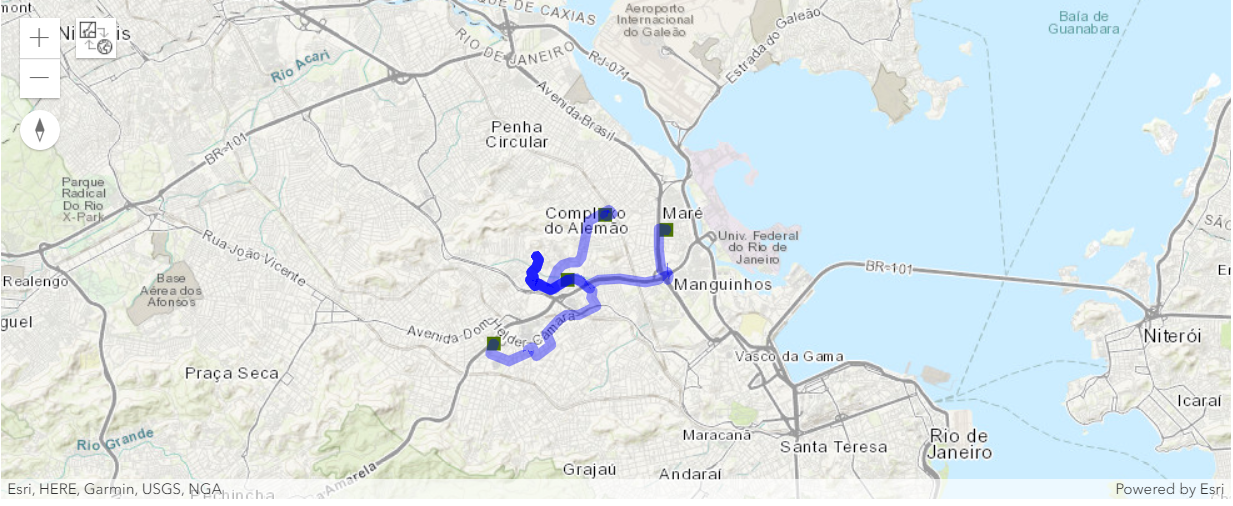

In [9]:
map1.draw(hospitals_fset, symbol={"type": "esriSMS","style": "esriSMSSquare",
                                  "color": [76,115,0,255],"size": 8,})

### Create incidents layer
Similarly, let us create the incient layer

In [10]:
incident_coords = '-43.281206,-22.865676'
reverse_geocode = geocoding.reverse_geocode({"x": incident_coords.split(',')[0], 
                                              "y": incident_coords.split(',')[1]})

incident_feature = Feature(geometry=reverse_geocode['location'], 
                           attributes=reverse_geocode['address'])

In [11]:
incident_fset = FeatureSet([incident_feature], geometry_type='esriGeometryPoint',
                          spatial_reference={'latestWkid': 4326})

Let us add the incident to the map

In [12]:
map1.draw(incident_fset, symbol={"type": "esriSMS","style": "esriSMSCircle","size": 8})

## Solve for closest hospital
By default the closest facility service would return only the closest location, so we need to specify explicitly the `default_target_facility_count` parameter as well as `return_facilities`.


In [13]:
result = cf_layer.solve_closest_facility(incidents=incident_fset,
                                        facilities=hospitals_fset,
                                        default_target_facility_count=4,
                                        return_facilities=True,
                                        impedance_attribute_name='TravelTime',
                                        accumulate_attribute_names=['Kilometers','TravelTime'])

Let us inspect the result dictionary

In [14]:
result.keys()

dict_keys(['messages', 'routes', 'facilities'])

Let us use the `routes` dictionary to construct line features out of the routes to display on the map

In [15]:
result['routes'].keys()

dict_keys(['fieldAliases', 'geometryType', 'spatialReference', 'features'])

In [16]:
result['routes']['features'][0].keys()

dict_keys(['attributes', 'geometry'])

Construct line features out of the routes that are returned.

In [17]:
line_feat_list = []
for line_dict in result['routes']['features']:
    f1 = Feature(line_dict['geometry'], line_dict['attributes'])
    line_feat_list.append(f1)

In [18]:
routes_fset = FeatureSet(line_feat_list, 
                         geometry_type=result['routes']['geometryType'],
                         spatial_reference= result['routes']['spatialReference'])

Add the routes back to the map. The route to the closest hospital is in red

In [19]:
allocation_line_symbol_4 = {'type': 'esriSLS', 'style': 'esriSLSSolid',
                                'color': [0,0,255,100], 'width': 6}
map1.draw(routes_fset, symbol = allocation_line_symbol_4)

In [20]:
map1.clear_graphics()

## Analyze the results in a table
Since we parsed the routes as a `FeatureSet`, we can display the attributes easily as a `pandas` `DataFrame`.

In [21]:
df1 = routes_fset.sdf
df1

,ObjectID,FacilityID,FacilityRank,Name,IncidentCurbApproach,FacilityCurbApproach,IncidentID,StartTime,EndTime,StartTimeUTC,...,Total_Minutes,Total_TravelTime,Total_Miles,Total_Kilometers,Total_TimeAt1KPH,Total_WalkTime,Total_TruckMinutes,Total_TruckTravelTime,Shape_Length,SHAPE
0,1,1,1,Rua Tangapeme 133 - Location 1,1,1,1,None,None,None,...,None,5.225825,1.331738,2.143224,None,None,None,None,0.020191,"{""paths"": [[[-43.28127999999998, -22.865709999..."
1,2,4,2,Rua Tangapeme 133 - Location 4,1,2,1,None,None,None,...,None,11.971893,3.238469,5.211810,None,None,None,None,0.048701,"{""paths"": [[[-43.28127999999998, -22.865709999..."
2,3,3,3,Rua Tangapeme 133 - Location 3,1,2,1,None,None,None,...,None,14.426142,4.534989,7.298357,None,None,None,None,0.068872,"{""paths"": [[[-43.28127999999998, -22.865709999..."
3,4,2,4,Rua Tangapeme 133 - Location 2,1,1,1,None,None,None,...,None,18.209707,5.016254,8.072878,None,None,None,None,0.076224,"{""paths"": [[[-43.28127999999998, -22.865709999..."


Let us add the hospital addresses and incident address to this table and display only the relevant columns

In [22]:
df1['facility_address'] = hospitals_addresses
df1['incident_address'] = [incident_feature.attributes['Match_addr'] for i in range(len(hospitals_addresses))]

In [23]:
df1[['facility_address','incident_address','Total_Miles','Total_TravelTime']]


,facility_address,incident_address,Total_Miles,Total_TravelTime
0,"Estrada Adhemar Bebiano, 339 Del Castilho, Rio...","Rua Tangapeme 133, InhaÃºma, Rio de Janeiro, 20...",1.331738,5.225825
1,"R. JosÃ© dos Reis Engenho de Dentro, Rio de Jan...","Rua Tangapeme 133, InhaÃºma, Rio de Janeiro, 20...",3.238469,11.971893
2,"R. Dezessete, s/n MarÃ©, Rio de Janeiro RJ, 210...","Rua Tangapeme 133, InhaÃºma, Rio de Janeiro, 20...",4.534989,14.426142
3,"Rua Dr. Miguel Vieira Ferreira, 266 Ramos, Rio...","Rua Tangapeme 133, InhaÃºma, Rio de Janeiro, 20...",5.016254,18.209707


### Conclusion
Thus using the `network` module of the ArcGIS API for Python, you can solve for closest facilities from an incident location.